In [14]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')
import time

In [15]:
def objfuns(x):
    
    """ 
    This function calculates the objective function values of the two objective functions

    Parameters: 
        x (float): Candidate solution

    Returns: 
        f (list): objective function values for f1 and f2: [f1,f2]
    """
    
    f1 = x**2
    f2 = (x-2)**2
    f = [f1,f2]
    
    return f

In [16]:
def check_feasibility(x):
    
    """ 
    This function checks whether the candidate solution is feasible according to given constraint

    Parameters: 
        x (float): Candidate solution

    Returns: 
        feasibility_flag (bool): The flag that indicates whether the candidate solution is feasible. 
                                 If it is, then feasibility_flag = True, else False
    """
    
    # Set constraint values
    constr_ceiling = 10**5
    const_floor = -10**5
    
    # Check whether the candidate solution is valid subject to problem constraint, return True is yes and False if no
    if x <= constr_ceiling and x >= const_floor :
        feasibility_flag = True
    else:
        feasibility_flag = False
    
    return feasibility_flag   

In [17]:
def init_sol():
    
    """ 
    This function randomly generates a solution between 10^-5 and 3 as per report

    Parameters: None
    
    Returns: 
        init_sol (float): Initial solution
    """
    # Set random seed for all experiments
    np.random.seed(7)
    
    # Select initial solution between -1 and 1 as per report
    init_sol = np.random.uniform(-1, 1)
    
    return init_sol

In [18]:
def mutation(x, a):
    
    """ 
    This function mutates the decision variable according by sampling a Laplace distribution with a scale of 1 for 
    the first mutation or scale = std. dev. of all solutions seen thus far. (Smith, et. al., 2008)

    Parameters: 
        x (float): Candidate solution
        a (DataFrame): Dataframe containing the approximate pareto front and corresponding solutions

    Returns: 
        x_neighbour (float): The updated value for x used to determine the neighbouring solution
    """
    
    # If this is the first iteration, scale = 1, otherwise scale = std. dev. of all x's
    if len(a) == 1:
        scale = 1
    else:
        scale = a['x'].std()
    
    # Generate neighbouring solution by sampleing a Laplace distribution as per Smith, et. al. (2008)
    x_neighbour = np.random.laplace(x, scale = scale)
    
    return x_neighbour

In [19]:
def accept_rej(a_tilda, T):
    
    """ 
    This function calculates the acceptance probability for use by the Metropolis acceptance rule
    Solution A is strictly dominated by solution B when both objective function values are lower
    (for a minimisation problem)

    Parameters: 
        a_tilda (DataFrame): Archive dataframe containing non-dominated set of solutions
                             taking into account neighbouring solution and their objective function values
                             The second last entry corresponds to x, f1 and f2
                             The last entry corresponds to x', f1' and f2'
    
    Returns: 
        accept (bool): When true: accept solution x_new, when false, reject x_new
        delta_E (float): Change in energy as given by Smith, et. al. (2008)
    """

    # Calculate the cardinality of a_tilda
    a_tilda_card = len(a_tilda)
    
    # Generate random probability for use in the Metropolis acceptance rule evaluation
    metr_prob = random.random()
    
    # Declare a_tilda_x and a_tilda_x_new counters to count each solution that that dominates x and x_new
    a_tilda_x = 0
    a_tilda_x_new = 0
    
    # Extract f1, f2, f1' and f2' from the dataframe
    f1 = a_tilda.loc[len(a_tilda)-2,'f'][0]
    f2 = a_tilda.loc[len(a_tilda)-2,'f'][1]
    f1_new = a_tilda.loc[len(a_tilda)-1,'f'][0]
    f2_new = a_tilda.loc[len(a_tilda)-1,'f'][1]
    
    # Calculate the number of solutions in a_tilda that dominate those of x and x_new
    for i in range(len(a_tilda)):
        
        # Ensure that solution is not compared to itself
        if i != len(a_tilda)-2:
        
            # Check if solutions f1(i) and f2(i) dominate solutions f1 and f2
            if a_tilda.loc[i,'f'][0] < f1 and a_tilda.loc[i,'f'][1] < f2:

                # Increment counter
                a_tilda_x = a_tilda_x + 1
        
        # Ensure that solution is not compared to itself
        if i != len(a_tilda)-1:
            
            # Check if solutions f1(i) and f2(i) dominate solutions f1_new and f2_new
            if a_tilda.loc[i,'f'][0] < f1_new and a_tilda.loc[i,'f'][1] < f2_new:

                # Increment counter
                a_tilda_x_new = a_tilda_x_new + 1
    
    # Calcualte delta E
    delta_E = (a_tilda_x_new - a_tilda_x) / a_tilda_card
        
    # Calculate acceptance probability of x_new, accept_prob
    accept_prob = min(1,np.exp(-delta_E/T))
    
    # Determine whether to accept or reject based on Metropolis acceptance rule
    if metr_prob <= accept_prob:
        
        accept = True
        
    else:
        
        accept = False
    
    return accept, delta_E

In [20]:
def init_temp(T, degradations, delta_E_store, T0_method):
    
    """ 
    This function calculates the initial temperature based on either accept all, acceptance deviation (Talbi, 2009),
    or smith, as presented by Smith, et. al. (2008)
    
    For acceptance deviation, the euclidean distance between the solution set and coordinates (0,0)
    represent the objective function degradations

    Parameters: 
        a (DataFrame): Dataframe containing the approximate pareto front
        T (float): Current temperature
        method (str): Determines the method of calculating the initial temperature
                      "accept_all", "accept_dev", "smith"
        degradations (list): List of objective function degreadations observed during initial experiments
    
    Returns: 
        T: The "new" intial temperature
    """
    
    if T0_method == 'accept_all':
        
        # Make no change to the temperature
        T0 = T
        
    if T0_method == 'accept_dev':
        
        # Calculate the initial temperature according to acceptance deviation method outlined in Talbi (2009) with P = 0.9
        T0 = -3 * np.std(degradations) / np.log(0.9)
        
    if T0_method == 'smith':
        
        # Calculate the initial temperature according to acceptance deviation method outlined in Smith, et. al. (2008)
        T0 = np.mean(delta_E_store) / np.log(2)
    
    return T0
        

In [21]:
def cooling(T0, T, beta_lin, alpha_geo, beta_geo, epoch, cool_method, cool_heat):
    
    """ 
    This function carries out cooling/reheating according to either a linear or geometric cooling / reheating
    according to Talbi (2009)
    
    Parameters: 
        T0 (float): Initial temperature, used for slow cooling
        T (float): Current temperature
        alpha_geo (float): Cooling parameter for geometric cooling
        beta_geo (float): Reheating parameter for geometric reheating
        beta_lin (float): Reheating and cooling parameter for linear reheating
        epoch (int): Current epoch of the DBMOSA algorithm, used for logarithmic cooling
        cool_method (str): Cooling method - 'linear', 'geometric', 'logarithmic', or 'slow'
        cool_heat (str): Specifies cooling or heating ("cool" / "heat")
        
    Returns: 
        T_new (float): Updated temperature
        lin_flag (bool): Flag to indicate negative temparature has been reached (for use with final_temp stop. crit.)
    """
    # Initialise lin_flag
    lin_flag = False
    
    # Linear cooling / reheating
    if cool_method == 'linear':
        
        if cool_heat == 'cool':
            
            T_new = T - beta_lin
            
            # For linear only: if temp is below zero, keep at previous temp for remainder of run and set lin_flag
            if T_new <= 0:
                
                T_new = T
                lin_flag = True
        
        if cool_heat == 'heat':
            
            T_new = T + beta_lin
    
    # Geometric cooling / reheating
    if cool_method == 'geometric':
        
        if cool_heat == 'cool':
        
            T_new = T * alpha_geo
        
        if cool_heat == 'heat':
        
            T_new = T * beta_geo
        
    return T_new, lin_flag

In [22]:
def hyper_volume(a, approx_true):
    
    """ 
    This function calculates the hypervolume of the approximate pareto front as per Talbi (2009)

    Parameters: 
        a (DataFrame): Dataframe containing the approximate pareto front and corresponding solutions
    
    Returns: 
        area (float): The hypervolume (area) occupied by the pareto front solution w.r.t. the archive passed and Z.ref (Talbi, 2009:356)
        z_ref_f1 (float): Reference point of f1 from which the area is calculated
        z_ref_f2 (float): Reference point of f2 from which the area is calculated
    """
    # Initialise area
    area = 0
    
    # Create dataframe with solutions sorted by f1 in decending order
    area_calc = pd.DataFrame(a['f'].to_list(), columns = ['f1', 'f2']).sort_values(by=['f1'], ascending=False).reset_index(drop=True)
    
    # Calculate Z_ref for approximate pareto front
    if approx_true == 'approx':
        
        # Calculate Zref1 as per Talbi (2009:356) taking max(f1)*1.05 and max(f2)*1.05
        z_ref_f1 = max(area_calc['f1'])*1.05

        #Calculate Zref2 
        z_ref_f2 = max(area_calc['f2'])*1.05
    
    # Calculate Z_ref for approximate pareto front (no need for 1.05 factor as it has already been taken into account)
    elif approx_true == 'true': 
        
        # Calculate Zref1 as per Talbi (2009:356) taking max(f1)*1.05 and max(f2)*1.05
        z_ref_f1 = max(area_calc['f1'])

        #Calculate Zref2 
        z_ref_f2 = max(area_calc['f2'])
        

    # Calculate the area by summing areas of individual solutions w.r.t. Zref, subtracting overlapping volumes
    for i in range(len(area_calc)):
        
        # Calculate first area
        if i == 0:
            area = (z_ref_f1 - area_calc.loc[i,'f1']) * (z_ref_f2 - area_calc.loc[i,'f2']) 
            
        else:
           
            # Calculate additional area and add it to the cumulative area
            area = area + (z_ref_f2 - area_calc.loc[i,'f2']) * (area_calc.loc[(i-1),'f1'] - area_calc.loc[(i),'f1'])
   
    return area, z_ref_f1,z_ref_f2

In [23]:
def hyper_volume_actual(z_ref_f1, z_ref_f2):
    
    """ 
    This function calculates the hypervolume of the true pareto front as per Talbi (2009)
    The actual hypervolume will be used to calculate a ratio of the approximate pareto front 
    and the actual pareto front as per Anime (2009).

    Parameters: 
        z_ref_f1 (float): Reference point of f1 from which the area is calculated
        z_ref_f2 (float): Reference point of f2 from which the area is calculated
    
    Returns: 
        actual_area (float): The hypervolume (area) occupied by the true pareto front solution w.r.t. the archive passed and Z.ref (Talbi, 2009:356)

    """
        
    # Create list of 2000 x-values to use for true pareto approximation (limit @ z_ref_f1 and z_ref_f2)
    x_test = list(np.linspace(2-np.sqrt(z_ref_f2), np.sqrt(z_ref_f1), num=2000))
    function_plot_data = pd.DataFrame(data = x_test, columns = ['x'])
    
    # Calculate corresponding objective function values and append to dataframe as a column of lists [f1, f2]
    f=[]
    for i in range(len(function_plot_data)):

        function_plot_data.loc[i,'f1'] = objfuns(function_plot_data.loc[i,'x'])[0]
        function_plot_data.loc[i,'f2'] = objfuns(function_plot_data.loc[i,'x'])[1]
        f1 = function_plot_data.loc[i,"f1"]
        f2 = function_plot_data.loc[i,"f2"]
        f.append([f1,f2])
        
    function_plot_data["f"] = f
    
    # Calculate the true pareto front area using the hyper_volume function
    actual_area = hyper_volume(function_plot_data, approx_true="true")[0]

    return actual_area

In [24]:
def spread(a):
    
    """ 
    This function calculates the the spread indicator (i_s) of an approximate pareto front according to Talbi (2009)

    Parameters: 
        a (DataFrame): Dataframe containing the approximate pareto front and corresponding solutions
    
    Returns: 
        i_s (float): Spread indicator

    """
    # Order archive by ascending f1 values:
    for j in range(len(a)):
        
        a.loc[j,'f1'] = a.loc[j,'f'][0]
        
    a = a.sort_values(by='f1', ascending=True).reset_index(drop=True)

    # Calculate distances between consecuti
    for i in range(len(a)-1):

        a.loc[i,'d'] = np.sqrt((a.loc[i,'f'][1] - a.loc[i+1,'f'][1])**2 + (a.loc[i,'f'][0] - a.loc[i+1,'f'][0])**2)

    # Calculate mean distance
    d_bar = a['d'].mean()

    # Calculate 'd_diff' = abs(di - d_bar) / (len(a) - 1) as per Talbi (2009).
    a['d_diff'] = abs(a['d'] - d_bar) / (len(a) - 1)

    # Calculate spread indicator i_s as per Talbi (2009)
    i_s = a['d_diff'].sum()
    
    return i_s    

In [36]:
def DBMOSA(epoch_len="adaptive", n_iterations=10, c_max=5, d_max=10, T0_method="accept_all", 
           init_experiments=49, cool_method="geometric", alpha_geo=0.9, beta_geo=1.1, beta_lin_den=20, 
           stop_crit="epoch", num_accept=5, epoch_max=10, no_improve_count_max=5,
           final_temp=0.1, T0=250):
    
    # Start time
    start = time.time()
    
    # Generate initial solution and objective function values
    x = init_sol()
    f = objfuns(x)
    
    # Initialise archive and archive_tilda
    a = pd.DataFrame(columns=['x', 'f'])
    a_tilda = pd.DataFrame(columns=['x', 'f'])
    
    # Initialise iterations (t), epoch number (epoch), number of rejections (d), number of acceptances (c)
    # no improvement counter,accept_stop_counter and epoch_stop_counter
    t = 1
    epoch = 1
    d = 0
    c = 0
    no_improve_count = 0
    accept_stop_count = 0
    epoch_stop_count = 0
    
    # Initialise degradations list for use in initial temperature calculation
    # Initialise list to store all delta_E values for use in the initial temp calculation
    # Initialise no improvement counter
    # Initialise lin_flag -> flag to indicate final temparture has been exceeded for linear cooling & final_temp stop crit.
    # Initialise achive_area_prev for the storage of previous iteration's achive area
    # Initialise achive_area_max for the storage of the maximum archive are witnessed
    lin_flag = False
    degradations = []
    archive_area_prev = 0
    delta_E_store = []
    no_improve_count = 0
    archive_area_prev = 0
    achive_area_max = 0

    # Append current solution to archive and archive_tilda
    a = a.append(pd.DataFrame([[x,f]], columns=['x', 'f'])).reset_index(drop=True)
    a_tilda = a_tilda.append(pd.DataFrame([[x,f]], columns=['x', 'f'])).reset_index(drop=True)
    
    # Set current temperature to initial temperature
    T = T0

    # Initialise stop flag
    stop_flag = False

    # run until stopping criteria has been reached
    while stop_flag == False:

        # After specified experiments iteration, update T0/T
        if t == init_experiments:

            T = init_temp(T, degradations, delta_E_store, T0_method)
            
            # if T0 method is either smith or accept_dev, update beta_lin according to new T0
            if T0_method == 'smith' or T0_method == 'accept_dev':
                
                beta_lin = T / beta_lin_den

            # Reset acceptance and rejection counters
            c = 0
            d = 0

        # Calculate new fitness of f1_new and f2_new (sum(f1,f2)
        fitness = f[0] + f[1]

        # Initialise feasibilty flag that will be set to true when a feasible solution is generated
        feasibility_flag = False

        # Generate feasible neighbouring solution
        while feasibility_flag == False:

            x_new = mutation(x, a)
            feasibility_flag = check_feasibility(x_new)

        # Calculate objective function values for neighbouring solution
        f_new = objfuns(x_new)

        # Check if current archive includes x and append to archive tilda if not
        # if x not in a_tilda['x']:
        if not np.any(np.isclose(x, a_tilda['x'])):
            a_tilda = a.append(pd.DataFrame([[x,f]], columns=['x', 'f'])).reset_index(drop=True)

        # Update archive_tilda with new solution
        a_tilda = a.append(pd.DataFrame([[x_new,f_new]], columns=['x', 'f'])).reset_index(drop=True)

        # Determine whether or not to accept or reject the solution
        accept, delta_E = accept_rej(a_tilda, T)

        # Store values of abs(delta_E) for use in the initial temperature calculation
        delta_E_store.append(abs(delta_E))

        # if solution is accepted, set current solution to accepted solution, likewise for objective functions
        if accept == True:

            # Calculate new fitness of f1_new and f2_new (sum(f1,f2)
            fitness_new = f_new[0] + f_new[1]

            # Assign new solution to current solution
            x = x_new
            f = f_new

            # Increase acceptance counter
            c = c + 1
            
            # Increment accept_stop_counter when solution is accepted
            accept_stop_count = accept_stop_count + 1

        else:

            # Increase rejection counter
            d = d + 1
            
            # Reset accept_stop_count
            accept_stop_count = 0

        # Check if there is degradation in the accepted solution, if so, append degradation value to list
        if fitness_new > fitness:

            degradations.append(fitness-fitness_new)

        # Declare list to store dominated solutions
        x_dom = []

        # Check for all solutions in the archive, a, that are non-dominant
        for j in range(len(a_tilda)):

            for i in range(len(a_tilda)):

                # Ensure that solution is not compared to itself
                if i != j:

                    # Check if solutions f1(i) and f2(i) dominate solution f1(j) and f2(j)
                    if a_tilda.loc[j,'f'][0] > a_tilda.loc[i,'f'][0] and a_tilda.loc[j,'f'][1] > a_tilda.loc[i,'f'][1]:
                        
                        # Append x_dom with index of the dominated solution
                        x_dom.append(j)
                        break

        # Remove all solutions in a_tilda that are dominated which becomes the new archive of non-dominated solutions
        a = a_tilda.drop(x_dom).reset_index(drop=True)

        if epoch_len  == "static":
            
            # Store epoch counter to test whether epoch increments on current iteration
            epoch_current = epoch

            if t % n_iterations == 0:
                
                # Adjust temperature according to cooling schedule
                T, lin_flag = cooling(T0, T, beta_lin, alpha_geo, beta_geo, epoch, cool_method, cool_heat="cool")
                
                # Increment epoch counter
                epoch = epoch + 1
                
        if epoch_len  == "adaptive":
            
            # Store epoch counter to test whether epoch increments on current iteration
            epoch_current = epoch

            # Adjust temperature and increment epoch counter if c_max is reached, after initial experiments are completed
            if c == c_max and t > init_experiments:
                    
                # Adjust temperature according to cooling schedule
                T, lin_flag = cooling(T0, T, beta_lin, alpha_geo, beta_geo, epoch, cool_method, cool_heat="cool")

                # Increment epoch counter
                epoch = epoch + 1

                # Reset acceptance and rejection counters
                c = 0
                d = 0
                
            # Adjust temperature and increment epoch counter if d_max is reached, after initial experiments are completed
            if d == d_max and t > init_experiments:
                    
                # Adjust temperature according to reheating schedule
                T, lin_flag = cooling(T0, T, beta_lin, alpha_geo, beta_geo, epoch, cool_method, cool_heat="heat")

                # Increment epoch counter
                epoch = epoch + 1

                # Reset acceptance and rejection counters
                c = 0
                d = 0

        # Increment iteration counter
        t = t + 1

        # If stopping criteria is epoch based, check stopping criteria
        if stop_crit == "epoch":

            if epoch_current < epoch and accept_stop_count > num_accept:
                
                epoch_stop_count = epoch_stop_count + 1
                accept_stop_count = 0
                
                if epoch_stop_count == epoch_max:

                    stop_flag = True

        # If stopping criteria is improvement based and the initial experimentation phase is over,
        # when there is no improvement in archive hypervolume area oberved in no_improve_count_max iterations, set stopping flag
        if stop_crit == "improve" and t > init_experiments:
            
            # Calculate current archive hypervolume
            archive_area, z_ref_f1, z_ref_f2 = hyper_volume(a, approx_true="approx")
            
            # Check new archive hypervolume against previous, increment no_improve_count when an acceptable improvement is not seen
            if archive_area < achive_area_max:

                no_improve_count = no_improve_count + 1
#                 print(no_improve_count)
            
            # Check new archive hypervolume against previous, reset no_improve_count when an improvement is seen
            elif archive_area > achive_area_max:

                no_improve_count = 0
            
            # Check if no_improve_count has reached the stopping criteria. If so, set stop_flag to end run
            if no_improve_count == no_improve_count_max:

                stop_flag = True
    
            # Check if new archive area (hypervolume) exceeds the previous best/largest witnessed, if yes, assign value to achive_area_max
            if archive_area > achive_area_max:
                
                achive_area_max = archive_area
            
            # Store current archive area (hypervolume) for comparison in next iteration
            archive_area_prev = archive_area

        # If stopping criteria is final temp, set stop flag when final temperature is exceeded
        if stop_crit == "final_temp":

            if T <= final_temp or lin_flag == True:

                stop_flag = True
                
        # If algorithm takes longer than 3 minutes, break and return best archive found
        int_time = round(time.time() - start, 2)
        if int_time >= 360: break

    # Calculate the hypervolume of the current archive
    archive_area, z_ref_f1, z_ref_f2 = hyper_volume(a, approx_true="approx")

    # Calculate hypervolume of true/actual pareto front
    actual_area = hyper_volume_actual(z_ref_f1, z_ref_f2)

    # Calculate performance measure (archive_area / actual_area) as per Anime (2009). 
    # Values closer to 1 indicate a better approximate pareto front
    perf = archive_area / actual_area
    
    # Calculate spead indicator i_s as per Galbi (2009)
    i_s = spread(a)
    
    # Calculate total time taken
    total_time = round(time.time() - start, 2)
    
    return a, perf, i_s, total_time

In [29]:
a, perf, i_s, total_time = DBMOSA(epoch_len="adaptive", T0_method="smith", cool_method="geometric", stop_crit="improve")

In [32]:
a

,x,f,f1
0,0.434044,"[0.18839429213097084, 2.4522178396655154]",0.188394
1,1.451691,"[2.10740571647021, 0.30064315343016784]",2.107406
2,1.512300,"[2.287050383235233, 0.23785158242171303]",2.287050
3,1.514009,"[2.2922242862245654, 0.23618692012509207]",2.292224
4,0.109478,"[0.011985354056420788, 3.5740747868138243]",0.011985
...,...,...,...
115,1.019833,"[1.0400591767329581, 0.9607275123880094]",1.040059
116,1.613834,"[2.6044593233976627, 0.14912438442179243]",2.604459
117,1.566250,"[2.4531381845786515, 0.1881393056275607]",2.453138
118,1.998277,"[3.993110384560056, 2.9692327168626467e-06]",3.993110


In [33]:
for i in range(len(a)):
    
    a.loc[i,'f_sum'] = a.loc[i,'f'][0] + a.loc[i,'f'][1]

In [35]:
a.sort_values(by='f_sum')

,x,f,f1,f_sum
57,0.986643,"[0.9734637662353913, 1.0268930700782501]",0.973464,2.000357
115,1.019833,"[1.0400591767329581, 0.9607275123880094]",1.040059,2.000787
96,1.020607,"[1.0416390153774888, 0.9592102963378262]",1.041639,2.000849
38,0.962048,"[0.9255365391189866, 1.077344154907435]",0.925537,2.002881
77,0.960071,"[0.921736852936058, 1.0814517532361763]",0.921737,2.003189
...,...,...,...,...
97,1.924165,"[3.7024109655469903, 0.005750946502895558]",3.702411,3.708162
68,1.942110,"[3.7717897757572274, 0.003351296106658753]",3.771790,3.775141
19,0.006495,"[4.2187067449349574e-05, 3.9740615581453156]",0.000042,3.974104
60,0.004720,"[2.227517882291762e-05, 3.981143640133707]",0.000022,3.981166


In [607]:
np.sqrt((4.001580-3.866049)**2 + (1.140607e-03 - 1.559538e-07)**2)

0.13553579818479225

In [678]:
print(total_time)
print(perf)

7.54
0.988749276617168


In [ ]:
epoch_len_list = ["static", "adaptive"]
T0_method_list = ["accept_all", "accept_dev", "smith"]
cool_method_list = ["linear", "geometric"]
stop_crit_list = ["epoch", "improve", "final_temp"]
i = 0
time_tot = 0
data_store = pd.DataFrame(columns=['epoch_len', 'T0_method', 'cool_method', 'stop_crit', 'perf', 'i_s', 'num_sol','total_time'])

for epoch_len in epoch_len_list:
    for T0_method in T0_method_list:
        for cool_method in cool_method_list:
            for stop_crit in stop_crit_list:
                
                a, perf, i_s, total_time = DBMOSA(epoch_len = epoch_len, T0_method = T0_method, cool_method = cool_method, stop_crit = stop_crit)
                
                data_store.loc[i,'epoch_len'] = epoch_len
                data_store.loc[i,'T0_method'] = T0_method
                data_store.loc[i,'cool_method'] = cool_method
                data_store.loc[i,'stop_crit'] = stop_crit
                data_store.loc[i,'perf'] = perf
                data_store.loc[i,'i_s'] = perf
                data_store.loc[i,'num_sol'] = len(a)
                data_store.loc[i,'total_time'] = total_time
                
                i = i + 1              
                time_tot = round(time_tot + total_time,2)
                print(epoch_len, '/', T0_method, '/', cool_method, '/', stop_crit, '/', time_tot, 'sec')


static / accept_all / linear / epoch / 4.25 sec


In [682]:
data_store

,epoch_len,T0_method,cool_method,stop_crit,perf,i_s,num_sol,total_time
0,static,accept_all,linear,epoch,0.982931,0.982931,63,3.76
1,static,accept_all,linear,improve,0.992686,0.992686,97,59.7
2,static,accept_all,linear,final_temp,0.947896,0.947896,36,1.54
3,static,accept_all,geometric,epoch,0.985828,0.985828,64,3.61
4,static,accept_all,geometric,improve,0.998187,0.998187,334,362.6
5,static,accept_all,geometric,final_temp,0.995681,0.995681,169,132.3
6,static,accept_dev,linear,epoch,0.952347,0.952347,53,3.38


In [ ]:
a=pd.DataFrame(columns=['test'], data = [0])

In [ ]:
data_store.sort_values(by='perf', ascending=False)

In [ ]:
data_store.to_csv('DBMOSA Output.csv')

In [595]:
scatter = pd.DataFrame(a['f'].to_list(), columns = ['f1', 'f2'])
scatter['x'] = a['x']

In [596]:
x_test = list(np.linspace((2-np.sqrt(scatter['f2'].max()))-0.1, (np.sqrt(scatter['f1'].max()))+0.1, num=5000))
function_plot_data = pd.DataFrame(data = x_test, columns = ['x'])

for i in range(len(function_plot_data)):
    
    function_plot_data.loc[i,'f1'] = objfuns(function_plot_data.loc[i,'x'])[0]
    function_plot_data.loc[i,'f2'] = objfuns(function_plot_data.loc[i,'x'])[1]

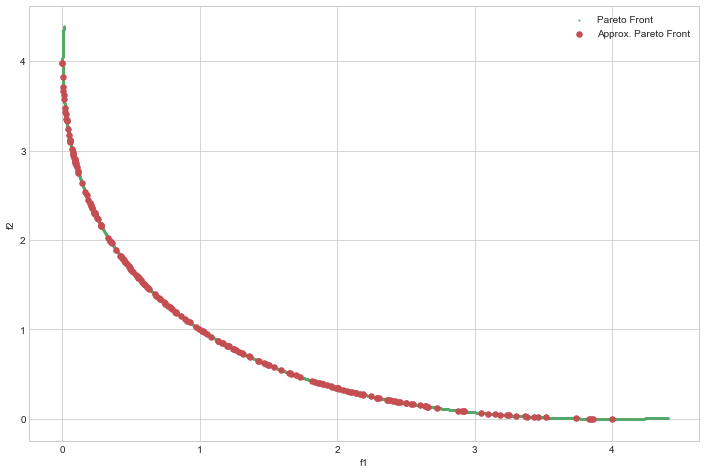

In [597]:
sns.set_color_codes("deep")
fig, ax1 = plt.subplots(figsize=[12, 8], nrows=1, ncols=1)

# ax1.scatter(x_test, y_test, color=["r" if t == 0 else "b" for t in target_test], label="data")
ax1.scatter(function_plot_data['f1'], function_plot_data['f2'], color='g', label="Pareto Front",s=1)
ax1.scatter(scatter['f1'], scatter['f2'], color="r", label="Approx. Pareto Front",s=30)
# ax1.scatter(bounds_bias[:, 0], bounds_bias[:, 1], color="black", s=1, label="Decision Boundary")
# ax1.set_title("Underfit SVM with Gaussian Kernel")
ax1.legend(loc='upper right',framealpha = 1, facecolor='w',fontsize='medium',
                ncol=1, fancybox=False, shadow=False)
ax1.set(xlabel='f1', ylabel='f2')

plt.savefig('Actual vs Approximate Pareto Front.png',bbox_inches = 'tight');

In [ ]:
# sns.set()
fig, ax1 = plt.subplots(figsize=[12, 8], nrows=1, ncols=1)

# ax1.scatter(x_test, y_test, color=["r" if t == 0 else "b" for t in target_test], label="data")
ax1.scatter(function_plot_data['x'], function_plot_data['f2'], color='b', label="f2",s=1)
ax1.scatter(function_plot_data['x'], function_plot_data['f1'], color='m', label="f1",s=1)
ax1.scatter(scatter['x'], scatter['f2'], color="r", label="Approx. Pareto Front f2",s=30)
ax1.scatter(scatter['x'], scatter['f1'], color="g", label="Approx. Pareto Front f1",s=30)
# ax1.scatter(bounds_bias[:, 0], bounds_bias[:, 1], color="black", s=1, label="Decision Boundary")
# ax1.set_title("Underfit SVM with Gaussian Kernel")
ax1.legend(loc='best',framealpha = 1, facecolor='w',fontsize='medium',
                ncol=1, fancybox=False, shadow=False)
ax1.set(xlabel='x', ylabel='f1 / f2')

plt.savefig('Actual vs Approximate Pareto Front Decision Space f2.png',bbox_inches = 'tight');

In [ ]:
scatter = pd.DataFrame(a['f'].to_list(), columns = ['f1', 'f2'])
scatter['x'] = a['x']
ax1 = scatter.plot.scatter(x=0,
                      y=1,
                      c='DarkBlue',
                      figsize = (10,6))

In [ ]:
print('a = ', a)

# Initialise feasibilty flag that will be set to true when a feasible solution is generated
feasibility_flag = False

# Generate feasible neighbouring solution
while feasibility_flag == False:
    
    x_new = mutation(x)
    feasibility_flag = check_feasibility(x_new)

print(x_new)
# Calculate objective function values for neighbouring solution
f_new = objfuns(x_new)

# Check if current archive includes x and append to archive tilda if not
# if x not in aa_tilda['x']:
if not np.any(np.isclose(x, a_tilda['x'])):
    a_tilda = a.append(pd.DataFrame([[x,f]], columns=['x', 'f'])).reset_index(drop=True)
print(a_tilda)
# Update archive_tilda with new solution
a_tilda = a.append(pd.DataFrame([[x_new,f_new]], columns=['x', 'f'])).reset_index(drop=True)
print(a_tilda)
# print(a_tilda)
# Determine whether or not to accept or reject the solution
accept = accept_rej(a_tilda, T)

# if solution is accepted, set current solution to accepted solution, likewise for objective functions
if accept == True:
    
    x = x_new
    f = f_new

# Declare list to store dominated solutions
x_dom = []
# Remove all solutions in the archive, a, that are non-dominant
for j in range(len(a_tilda)):
    
    
    for i in range(len(a_tilda)):
        
        # Ensure that solution is not compared to itself
        if i != j:

            # Check if solutions f1(i) and f2(i) dominate solution f1(j) and f2(j)
            if a_tilda.loc[j,'f'][0] > a_tilda.loc[i,'f'][0] and a_tilda.loc[j,'f'][1] > a_tilda.loc[i,'f'][1]:
                # Append x_dom with index of the dominated solution
                x_dom.append(j)
                break
print(x_dom)
# Remove all soltions in a_tilda that are dominated which becomes the new archive of non-dominated solutions
a = a_tilda.drop(x_dom).reset_index(drop=True)
print('a = ', a)

In [ ]:
(z_ref_f1 - area_calc.loc[0,'f1']) * (z_ref_f2 - area_calc.loc[0,'f2']) 

In [ ]:
archive_tilda = pd.DataFrame(columns=['x', 'f'])
archive_tilda = archive_tilda.astype({'f': object})

In [ ]:
f = [None] * 2
for i in range(20):
    archive_tilda.loc[i,'x'] = i
#     archive_tilda.loc[i,'y'] = i
    f = objfuns(i)
#     f[0] = objfuns(i)[0]
#     f[1] = objfuns(i)[1]
    archive_tilda.loc[i,'f'] = f


In [ ]:
f=[]
for i in range(len(function_plot_data)):
    
    f1 = function_plot_data.loc[i,"f1"]
    f2 = function_plot_data.loc[i,"f2"]
    f.append([f1,f2])
function_plot_data["f"] = f

hyper_volume(function_plot_data)

In [ ]:
x = 15

In [ ]:
x not in archive_tilda['x']

In [ ]:
archive_tilda.loc[20,'x'] = 

In [ ]:
archive_tilda

In [ ]:
archive

In [ ]:
len(archive)-2

In [ ]:
archive.loc[1,'f2']

In [ ]:
archive.loc[len(archive)-1,'f2']

In [ ]:
# Initialise archive, a
archive = pd.DataFrame(columns=['x', 'f1', 'f2'])

# Generate initial solution
x = init_sol()

# Calculate objective fucntion values
f1 = objfuns(x)[0]
f2 = objfuns(x)[1]

# Append current solution to archive
archive.append(pd.DataFrame([[x,f1,f2]], columns=['x', 'f1', 'f2']))

In [ ]:
random.randint(-5, 5)

In [ ]:
n =0

In [ ]:
x=0

In [ ]:
mutation(x,n)

In [ ]:
random.random()
random.uniform(10E-5, 10E5) 

In [ ]:
rand_num = random.random()

In [ ]:
rand_num = random.random()
rand_num*10**n

In [ ]:
a = pd.Series([1,2,3,4])

In [ ]:
archive_tilda

In [ ]:
archive_tilda['asd'] = [archive_tilda['x'], archive_tilda['f']]

In [ ]:
archive_tilda.loc[20,'x'] = 100
archive_tilda.loc[20,'f'] = [100,200]
archive_tilda

In [ ]:
archive_tilda.loc[len(archive_tilda)-2,'f1']

In [ ]:
f1 = archive_tilda.loc[len(archive_tilda)-2,'f1']
f2 = archive_tilda.loc[len(archive_tilda)-2,'f2']
f1_new = archive_tilda.loc[len(archive_tilda)-1,'f1']
f2_new = archive_tilda.loc[len(archive_tilda)-1,'f2']

In [ ]:
f2

In [ ]:
archive_tilda.loc[15,'f1'] < f1 and archive_tilda.loc[15,'f2'] < f2

In [ ]:
archive_tilda.loc[15,'f2'] < f2

In [ ]:
archive_tilda

In [ ]:
archive_tilda.loc[]

In [ ]:
ax1 = function_plot_data.plot.scatter(x='f1',
                                      y='f2',
                                      c='DarkRed',
                                      figsize = (10,6),
                                      s=1)

plt.savefig('Objective space Plot actual (x to 2.5).png',bbox_inches = 'tight');